<a href="https://colab.research.google.com/github/cs-amy/project-codebase/blob/main/notebooks/Word_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN Sliding-Window Model for 3-Letter Word De-Obfuscation**
Stage 2 of MSc Project — Ashraf Muhammed Yusuf

# **1. Colab Environment Setup**

In [1]:
# Install dependencies
!pip install -q tensorflow matplotlib

In [2]:
# Optional - Install font (we will use it to generate images)
# Colab / Ubuntu repositories already ship Roboto
!sudo apt-get -qq update
!sudo apt-get -qq install fonts-roboto

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# Import dependencies
import os, sys, random, itertools, pathlib, math, shutil, io, requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm as tq
from tqdm import tqdm
from pathlib import Path
from glob import glob
from tensorflow.keras import layers, models, mixed_precision
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple

In [4]:
# 1.3 Mount Drive & define base path
# Mount Drive so you can read datasets and write checkpoints
# Link to Drive:
# https://drive.google.com/drive/folders/1sfNG1PkmTPBe1wOSQXZmfdkvR97Hn9lk?usp=sharing
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Constants & Data Generation**
This block generates the 'three-letter words' dataset afresh if you do not already have it (You can access it here: https://drive.google.com/drive/folders/1kygA17GiCeCs8qTeDBEndU6TkXnEu-m7?usp=drive_link). It synthesizes three three-letter words from the character dataset (https://drive.google.com/drive/folders/1eUaTNW8zVjTArg0JszbCdCEq0tTdx89n?usp=drive_link).

In [5]:
# paths & constants
BASE_PATH = Path("/content/drive/MyDrive/MScProject")
GLYPH_DIR = Path(f"{BASE_PATH}/data/characters/train")
DATA_ROOT = Path(f"{BASE_PATH}/data/words3")
CKPT_DIR = f"{BASE_PATH}/words3_ckpt_best.keras"
BATCH = 64
IMG_H = IMG_W = 64
IMG_SHAPE = (IMG_H, IMG_W)
PATCH_W = IMG_W // 3
VARIANTS_PER = 5 # per word
EXPECTED_CLASSES = 26**3 # 26³ = 17,576
FINAL_TEST_FRAC = 0.20
SEED = 42
PATCH_W = IMG_W // 3 # 21 when IMG_W = 64
N_VARIANTS = 4 # number of images per class
FRACTION = 0.15 # 15 %
train_dir = DATA_ROOT / "train"
test_dir  = DATA_ROOT / "test"

random.seed(SEED)

In [6]:
"""
- Generates a single ‘train/’ directory with 17,576 class folders (AAA … ZZZ)
- Each class contains N_VARIANTS PNG images rendered on-the-fly (no external glyph reuse)
- Obfuscation applied per-character (leet + homoglyph + random spacing jitter)
- Idempotent: if the train folder already has 17,576 classes it exits immediately
"""

def obfuscate_char(ch: str) -> str:
  mode = random.choices(("plain", "leet", "homo"), weights=(0.5, 0.4, 0.1))[0]
  if mode == "leet" and ch in LEET:
    return random.choice(LEET[ch])
  if mode == "homo" and ch in HOMO:
    return HOMO[ch]
  return ch

def render_patch(ch: str) -> Image.Image:
  # Return a 64×21 monochrome patch for a single (possibly obfuscated) char
  patch = Image.new("L", (PATCH_W, IMG_H), color=255)
  draw  = ImageDraw.Draw(patch)
  draw.text((4, 4), obfuscate_char(ch), fill=0, font=FONT)
  return patch

def stitch_word(word: str, out_file: Path):
  canvas = Image.new("L", (IMG_W, IMG_H), color=255)
  for idx, ch in enumerate(word):
    glyph = render_patch(ch)
    canvas.paste(glyph, (idx * PATCH_W, 0))
  # light horizontal jitter
  if random.random() < 0.3:
    dx = random.randint(-2, 2)
    canvas = canvas.transform(canvas.size, Image.AFFINE, (1, 0, dx, 0, 1, 0))
  canvas.save(out_file)

AAA = train_dir / "AAA"
dataset_ready = AAA.is_dir() and any(AAA.glob("*.png"))

if dataset_ready:
  print("words3/train already complete – nothing to do.")
else:
  # Define font
  try:
    FONT_PATH = "/usr/share/fonts/truetype/roboto/Roboto-Medium.ttf"
    # A big font size makes the letters cut-off at the edges
    # when we slice through the images,
    # mimicking real-world scenarios where this operation
    # may not produce clean cuts of letters
    FONT_SIZE = 40
    FONT = ImageFont.truetype(FONT_PATH, FONT_SIZE)
    print("Using Roboto Medium font to generate images")
  except Exception as e:
    print(f"Error loading font: {e}")
    print("Using default font to generate images")
    FONT = ImageFont.load_default()

  # mapping tables (uppercase only)
  LEET = {
    'A': ['Α', '4', 'Д', 'Ä', 'Á', 'À', 'Â', '@', 'Δ'],
    'B': ['8', 'β', 'Β', 'В'],
    'C': ['Ç', 'Ć', 'Č', 'С'],
    'D': ['Ð', 'Ď'],
    'E': ['3', 'Σ', 'Έ', 'Ε', 'Е', 'Ë', 'É', 'È', 'Ê'],
    'F': ['Φ', 'Ƒ'],
    'G': ['6', 'Ğ', 'Ģ', 'Γ'],
    'H': ['Η', 'Н'],
    'I': ['1', '|', 'Í', 'Ì', 'Î', 'Ï', 'И'],
    'J': ['Ј'],
    'K': ['Κ', 'К'],
    'L': ['Ι', 'Ł', 'Ĺ', 'Л'],
    'M': ['Μ', 'М'],
    'N': ['Ν', 'Ń', 'Ñ', 'Н'],
    'O': ['0', 'Θ', 'Ο', 'Ө', 'Ø', 'Ö', 'Ó', 'Ò', 'Ô'],
    'P': ['Ρ', 'Р'],
    'Q': ['Φ'],
    'R': ['®', 'Я', 'Ř', 'Ŕ'],
    'S': ['5', '$', 'Ѕ', 'Ś', 'Š'],
    'T': ['Τ', 'Т'],
    'U': ['Υ', 'Ц', 'Ü', 'Ú', 'Ù', 'Û'],
    'V': ['Ѵ', 'V'],
    'W': ['Ω', 'Ѡ', 'Ψ', 'Ш', 'Щ'],
    'X': ['Χ', 'Ж', 'Х'],
    'Y': ['Υ', 'Ү', 'Ý', 'Ÿ'],
    'Z': ['Ζ', 'Ż', 'Ź', 'Ž', 'З', '2']
  }
  HOMO = {
    'A':'Α',
    'B':'Β',
    'C':'С',
    'E':'Ε',
    'H':'Н',
    'K':'Κ',
    'M':'Μ',
    'O':'О',
    'P':'Р',
    'T':'Τ',
    'X':'Χ',
    'Y':'Υ',
    'Z':'Ζ'
  }

  # wipe & rebuild train directory (safe for colab runs)
  if train_dir.exists():
    shutil.rmtree(train_dir)
  train_dir.mkdir(parents=True, exist_ok=True)

  # generate every word (AAA … ZZZ)
  alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  all_words = ["".join(tpl) for tpl in itertools.product(alphabet, repeat=3)]

  for word in tqdm(all_words, desc="Generating train"):
    cls_dir = train_dir / word
    cls_dir.mkdir(parents=True, exist_ok=True)
    for k in range(N_VARIANTS):
      stitch_word(word, cls_dir / f"{word}_{k}.png")

  print("Training set complete.")

words3/train already complete – nothing to do.


In [7]:
"""
- Make a permanent 15 % test split on Drive
- Assumes you have a single words3/train/AAA … ZZZ/*.png structure already.
- Creates /words3/test/AAA … ZZZ/ and MOVES files (no duplication).
- Safe to rerun – will skip classes already processed.
"""
import tqdm

AAA = test_dir / "AAA"
dataset_ready = AAA.is_dir() and any(AAA.glob("*.png"))

if dataset_ready:
  print("words3/test already complete – nothing to do.")
else:
  test_dir.mkdir(parents=True, exist_ok=True)

  # split loop
  for cls_dir in tqdm.tqdm([d for d in train_dir.iterdir() if d.is_dir()], desc="Creating 15 % test split"):
    tgt_cls = test_dir / cls_dir.name
    tgt_cls.mkdir(parents=True, exist_ok=True)

    # list PNGs still in train/ for this class (those already moved last run are gone)
    imgs = list(cls_dir.glob("*.png"))
    if not imgs: # all imgs already moved in a previous run
      continue

    # number to move: 15% rounded down, but keep ≥1 in train/
    n_move = max(1, math.floor(len(imgs) * FRACTION))
    n_move = min(n_move, len(imgs) - 1) # safeguard: leave ≥1

    random.shuffle(imgs)
    for img in imgs[:n_move]:
      shutil.move(str(img), tgt_cls / img.name)

  print("Test split ready.")
  print("Train images:", sum(1 for _ in train_dir.rglob("*.png")))
  print("Test images:", sum(1 for _ in test_dir.rglob("*.png")))

words3/test already complete – nothing to do.


# **3. Load & Freeze the Single-Char Model**

In [8]:
base_model = tf.keras.models.load_model(f"{BASE_PATH}/char_cnn_ckpt_best.keras")
base_model.trainable = False # freeze weights initially
print("Base model frozen — params:", base_model.count_params())

Base model frozen — params: 2455450


# **4. Data Loading & Splitting**

In [9]:
def normalise(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SHAPE,
  color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=42
)

# Val dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SHAPE,
  color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  shuffle=False,
  seed=42
)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SHAPE,
  color_mode="grayscale",
  shuffle=False
)

# Generate class names for future reference
class_names = train_ds.class_names

# Preprocess datasets
train_ds = (train_ds
            .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
            .apply(tf.data.experimental.ignore_errors())
            .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds
          .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
          .apply(tf.data.experimental.ignore_errors())
          .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds
           .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
           .apply(tf.data.experimental.ignore_errors())
           .prefetch(tf.data.AUTOTUNE))

Found 52728 files belonging to 17576 classes.
Using 42183 files for training.
Found 52728 files belonging to 17576 classes.
Using 10545 files for validation.
Found 17576 files belonging to 17576 classes.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


# **5. Visual Sanity Check**

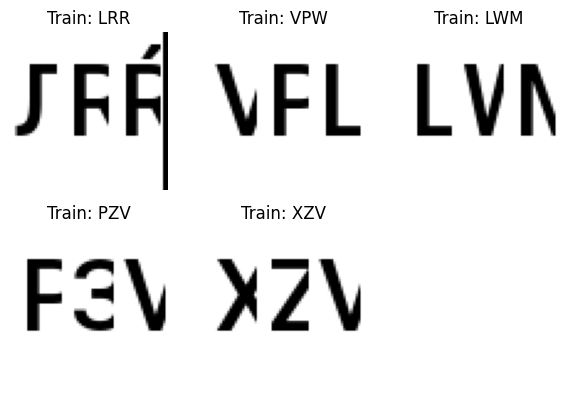

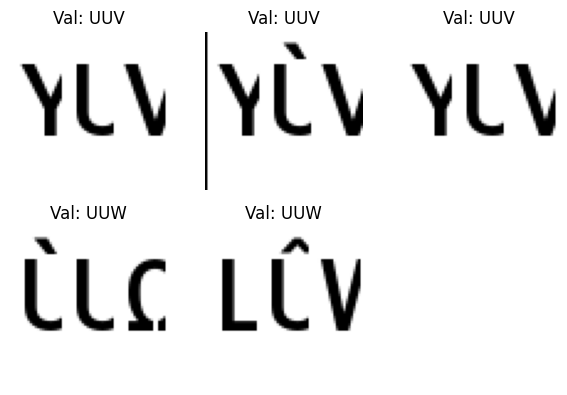

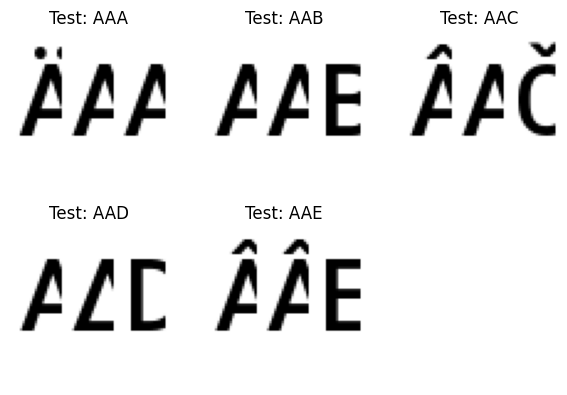

In [10]:
# Utility to display examples from each set
def show_examples(ds, ds_name, num=5):
  # Take one batch
  for images, labels in ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    break

  plt.figure(figsize=(6,6))
  for i in range(num):
    ax = plt.subplot(3, 3, i+1)
    img = images[i].squeeze()  # shape: (H,W) since grayscale
    lbl = class_names[labels[i].argmax()]
    plt.imshow(img, cmap='gray')
    plt.title(f"{ds_name}: {lbl}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Display 5 examples from each split
show_examples(train_ds, "Train")
show_examples(val_ds, "Val")
show_examples(test_ds, "Test")

# **6. Build the Sliding-Window Model**

In [11]:
def extract_patch(x, idx):
  start = idx * PATCH_W
  return x[:, :, start:start+PATCH_W, :] # (None, 64, 21, 1)

inputs = tf.keras.Input(shape=(IMG_H, IMG_W, 1))
logits = []
for i in range(3):
  patch = layers.Lambda(lambda z, i=i: extract_patch(z, i))(inputs)
  patch = layers.Resizing(IMG_H, IMG_H)(patch) # -> (64 x 64 x 1)
  # Re-use frozen base_model (shared weights)
  logits.append(base_model(patch)) # (None, 26)
concat = layers.Concatenate()(logits) # (None, 78)

# FC + ReLU
x = layers.Dense(256, activation='relu')(concat)

# Dropout Regularisation
x = layers.Dropout(0.5)(x)

# Output
outputs = layers.Dense(EXPECTED_CLASSES, activation='softmax')(x)

# Create model & print summary
model = models.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 21, 1) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 21, 1) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64, 21, 1) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 64, 64, 1) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 64, 64, 1) │          0 │ lambda_1[0][0]    │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 64, 64, 1) │          0 │ lambda_2[0][0]    │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 26)        │  2,455,450 │ resizing[0][0],   │
│ (Functional)        │                   │            │ resizing_1[0][0], │
│                     │                   │            │ resizing_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 78)        │          0 │ functional_1[0][… │
│ (Concatenate)       │                   │            │ functional_1[1][… │
│                     │                   │            │ functional_1[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 17576)     │  1,388,504 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,843,954 (14.66 MB)

 Trainable params: 1,388,504 (5.30 MB)

 Non-trainable params: 2,455,450 (9.37 MB)

# **7. Compilation & Callbacks**

In [12]:
# Compile model
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

# Callbacks
# 1. Checkpoint
ckpt = tf.keras.callbacks.ModelCheckpoint(
    CKPT_DIR,
    save_best_only=True, # keep only the best model
    monitor='val_loss'
)

# 2. Early stopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # stop ~5 epochs after val_loss stalls
    restore_best_weights=True
)

# 3. LR Scheduler
lr_s = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

cb = [ckpt, es, lr_s]

# **8. Train**

In [13]:
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=cb
)

Epoch 1/20
    659/Unknown 205s 308ms/step - accuracy: 3.3899e-04 - loss: 9.7918

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


660/660 ━━━━━━━━━━━━━━━━━━━━ 250s 376ms/step - accuracy: 3.3933e-04 - loss: 9.7918 - val_accuracy: 0.0216 - val_loss: 9.4072 - learning_rate: 0.0010
Epoch 2/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 254s 385ms/step - accuracy: 0.0192 - loss: 9.1584 - val_accuracy: 0.0509 - val_loss: 8.9925 - learning_rate: 0.0010
Epoch 3/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 250s 378ms/step - accuracy: 0.0406 - loss: 8.8326 - val_accuracy: 0.0759 - val_loss: 8.6767 - learning_rate: 0.0010
Epoch 4/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 253s 382ms/step - accuracy: 0.0564 - loss: 8.5790 - val_accuracy: 0.0962 - val_loss: 8.4152 - learning_rate: 0.0010
Epoch 5/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 253s 382ms/step - accuracy: 0.0712 - loss: 8.3683 - val_accuracy: 0.1098 - val_loss: 8.1875 - learning_rate: 0.0010
Epoch 6/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 249s 377ms/step - accuracy: 0.0723 - loss: 8.1862 - val_accuracy: 0.1209 - val_loss: 7.9839 - learning_rate: 0.0010
Epoch 7/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 253s 382ms/step - accuracy: 0.0

# **9. (Optional) Unfreeze last N Conv Blocks and Re-train**
If accuracy is low, you should try unfreezing the last conv blocks of the character model.

In [15]:
def unfreeze_last_conv_blocks(base_model, N=1):
    """
    Set `trainable=True` for the last N Conv2D layers (+ their following
    BatchNorm, ReLU, etc. if present) in `base_model`.  All earlier layers
    remain frozen.

    Parameters
    ----------
    base_model : tf.keras.Model
        The pretrained character-classifier model.
    N : int
        How many of the deepest Conv2D layers (counted from the output side)
        to unfreeze.
    """
    # 1) Freeze everything first
    for layer in base_model.layers:
        layer.trainable = False

    # 2) Collect indices of all Conv2D layers
    conv_idx = [idx for idx, layer in enumerate(base_model.layers)
                if isinstance(layer, tf.keras.layers.Conv2D)]

    # 3) Decide which indices to unfreeze (last N)
    if N > len(conv_idx):
        raise ValueError(f"Model only has {len(conv_idx)} Conv2D layers, "
                         f"cannot unfreeze {N}")

    to_unfreeze = conv_idx[-N:]

    # 4) Unfreeze selected Conv2D layers *and* everything that follows them
    #    (so the gradient flows through BN / ReLU / Dense that depend on them)
    for idx in to_unfreeze:
        for layer in base_model.layers[idx:]:
            layer.trainable = True

    print(f"Unfroze {N} Conv2D block(s) starting with layer(s):",
          [base_model.layers[i].name for i in to_unfreeze])

N = 1
unfreeze_last_conv_blocks(base_model, N=1)

# Re-compile with lower LR
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

# Train for another 5-10 epochs
ft_history = model.fit(
  train_ds,
  validation_data=val_ds,
  initial_epoch=history.epoch[-1] + 1,
  epochs=history.epoch[-1] + 10,
  callbacks=cb
)

Unfroze 1 Conv2D block(s) starting with layer(s): ['conv2d_2']
Epoch 21/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 435s 654ms/step - accuracy: 0.1800 - loss: 5.8714 - val_accuracy: 0.2014 - val_loss: 5.6855 - learning_rate: 1.0000e-04
Epoch 22/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 417s 632ms/step - accuracy: 0.2380 - loss: 5.6456 - val_accuracy: 0.2136 - val_loss: 5.6024 - learning_rate: 1.0000e-04
Epoch 23/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 414s 628ms/step - accuracy: 0.2609 - loss: 5.5322 - val_accuracy: 0.2276 - val_loss: 5.5408 - learning_rate: 1.0000e-04
Epoch 24/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 415s 628ms/step - accuracy: 0.2865 - loss: 5.4432 - val_accuracy: 0.2529 - val_loss: 5.4611 - learning_rate: 1.0000e-04
Epoch 25/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 423s 640ms/step - accuracy: 0.3051 - loss: 5.3637 - val_accuracy: 0.2617 - val_loss: 5.4105 - learning_rate: 1.0000e-04
Epoch 26/29
660/660 ━━━━━━━━━━━━━━━━━━━━ 415s 628ms/step - accuracy: 0.3251 - loss: 5.2936 - val_accuracy: 0.2724 - val_loss: 5.3604

In [ ]:
def merge_histories(*hists):
    merged = {}
    for h in hists:
        for k, v in h.history.items():
            merged.setdefault(k, []).extend(v)
    return merged


# Merge histories
history = merge_histories(history, ft_history)

# **10. Evaluation & Visualization**

In [ ]:
# Load best checkpoint's weights
model.load_weights(CKPT_DIR)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Gather all ground-truths and predictions
y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
  preds = model.predict(batch_x)
  y_pred.extend(np.argmax(preds, axis=1))
  y_true.extend(np.argmax(batch_y.numpy(), axis=1))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Training curves
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'],    label='train_acc')
plt.plot(epochs, history.history['val_accuracy'],label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'],    label='train_loss')
plt.plot(epochs, history.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# **11. Qualitative Error Analysis**

In [ ]:
# Plot a few misclassified 3-letter words
mis_idx = [i for i,(t,p) in enumerate(zip(y_true, y_pred)) if t != p]
show_examples(test_ds.unbatch().skip(mis_idx[0]), "Misclassified example")